# Keras Baseline (MLP) Modell mit den im Vorfeld aufbereiteten Daten
Das bestehende MLP Modell wurde in Keras überführt. Die größten Teile des Codes wurden dabei kopiert und nicht bearbeitet, da es fast 1 zu 1 in Keras verwendet werden kann. D.h. die meisten Kommentare wurden bereits von sensalytics eingefügt. Die Daten wurden im Vorfeld dieser Thesis bereits aufbereitet um im MLP zum Einsatz zu kommen. Die Hyperparameter wurden bereits optimiert.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import tempfile
import pathlib
import numpy as np
import random as python_random
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

Run this cell to mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defaul values

In [ ]:
FILE_NAME = "PQM_691.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/tensorflow/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME
EPOCHS=1000
VALIDATION_SPLIT=0.2
RMS_PROP=0.001
ACTIVATION='softsign'
frac = 0.9

set seeds (needs to be set inside the python script - not sure if it is necesarry in colab)

In [ ]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

read dataset from csv

In [ ]:
print(CSV_PATH)

/content/drive/MyDrive/sensalytics/tensorflow/PQM_691.csv


In [ ]:
raw_dataset = pd.read_csv(CSV_PATH, header=0, 
                              na_values="?", comment='\t',
                              sep=",", skipinitialspace=False)
dataset = raw_dataset.copy()

In [ ]:
dataset

,LOCATION_ID,TRACK_DATETIME_LOCAL,TIME_ID,IN_COUNT_LAST_10_MINUTES,OUT_COUNT_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_LAST_10_MINUTES,IN_COUNT_SECOND_LAST_10_MINUTES,OUT_COUNT_SECOND_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,IN_COUNT_THIRD_LAST_10_MINUTES,OUT_COUNT_THIRD_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,IN_COUNT_FOURTH_LAST_10_MINUTES,OUT_COUNT_FOURTH_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,POS_OCCUPANCY_NEXT_10_MINUTES
0,691,2021-09-30 10:22:00.000000,102,28,38,71,78,44,28,73,78,33,27,64,69,32,25,58,63,10
1,691,2021-08-28 08:31:00.000000,83,41,46,68,71,39,37,73,77,42,21,60,73,36,33,50,54,12
2,691,2021-09-25 11:14:00.000000,111,62,65,167,175,85,63,165,173,69,66,157,162,70,57,147,158,19
3,691,2021-09-11 07:55:00.000000,75,27,28,50,57,29,15,46,53,27,14,36,44,15,8,28,32,11
4,691,2021-08-19 17:41:00.000000,174,50,37,106,110,51,48,98,101,49,50,98,103,49,61,100,106,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38069,691,2021-08-17 13:47:00.000000,134,37,30,84,90,43,38,72,81,41,37,76,79,36,32,74,78,8
38070,691,2021-09-03 18:36:00.000000,183,39,46,94,101,53,47,93,99,41,54,99,109,58,59,107,111,15
38071,691,2021-09-01 12:31:00.000000,123,45,54,70,81,46,47,83,89,40,61,92,103,53,62,108,114,10
38072,691,2021-08-14 07:51:00.000000,75,37,30,55,62,29,22,48,53,27,11,36,43,17,12,28,32,8


drop location id and track datetime

In [ ]:
if dataset.get('LOCATION_ID') is not None:
    dataset.pop('LOCATION_ID')
if dataset.get('TRACK_DATETIME_LOCAL') is not None:
    dataset.pop('TRACK_DATETIME_LOCAL')

get prediction attribute

In [ ]:
csv_headers = raw_dataset.columns.tolist()
PREDICTION_ATTRIBUTE = csv_headers[len(csv_headers) - 1]
print('attr to predict:', PREDICTION_ATTRIBUTE)

attr to predict: POS_OCCUPANCY_NEXT_10_MINUTES


remove empty values

In [ ]:
dataset = dataset.dropna()
print(dataset.isna().sum())

TIME_ID                                       0
IN_COUNT_LAST_10_MINUTES                      0
OUT_COUNT_LAST_10_MINUTES                     0
AVG_STORE_OCCUPANCY_LAST_10_MINUTES           0
MAX_STORE_OCCUPANCY_LAST_10_MINUTES           0
IN_COUNT_SECOND_LAST_10_MINUTES               0
OUT_COUNT_SECOND_LAST_10_MINUTES              0
AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES    0
MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES    0
IN_COUNT_THIRD_LAST_10_MINUTES                0
OUT_COUNT_THIRD_LAST_10_MINUTES               0
AVG_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES     0
MAX_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES     0
IN_COUNT_FOURTH_LAST_10_MINUTES               0
OUT_COUNT_FOURTH_LAST_10_MINUTES              0
AVG_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES    0
MAX_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES    0
POS_OCCUPANCY_NEXT_10_MINUTES                 0
dtype: int64


get the train and test dataset

In [ ]:
train_dataset = dataset.sample(frac=frac, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train stats

In [ ]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
print(train_stats)

                                              count        mean  ...    75%    max
TIME_ID                                     34267.0  141.454548  ...  172.0  220.0
IN_COUNT_LAST_10_MINUTES                    34267.0   48.979835  ...   59.0  123.0
OUT_COUNT_LAST_10_MINUTES                   34267.0   46.636560  ...   55.0  120.0
AVG_STORE_OCCUPANCY_LAST_10_MINUTES         34267.0  162.588642  ...  235.0  452.0
MAX_STORE_OCCUPANCY_LAST_10_MINUTES         34267.0  169.756559  ...  244.0  458.0
IN_COUNT_SECOND_LAST_10_MINUTES             34267.0   49.062071  ...   59.0  127.0
OUT_COUNT_SECOND_LAST_10_MINUTES            34267.0   46.324510  ...   55.0  120.0
AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES  34267.0  160.278723  ...  232.0  452.0
MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES  34267.0  167.476464  ...  240.0  458.0
IN_COUNT_THIRD_LAST_10_MINUTES              34267.0   48.889923  ...   59.0  131.0
OUT_COUNT_THIRD_LAST_10_MINUTES             34267.0   45.949631  ...   55.0  120.0
AVG_

normalize the data

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

remove prediction attr

In [ ]:
normed_train_data.pop(PREDICTION_ATTRIBUTE)
normed_test_data.pop(PREDICTION_ATTRIBUTE)

10       2.675027
19      -0.809190
43       0.291089
52      -0.259050
55      -0.625810
           ...   
38021   -1.175949
38026   -0.992569
38042    1.758128
38049   -0.442430
38071   -0.259050
Name: POS_OCCUPANCY_NEXT_10_MINUTES, Length: 3807, dtype: float64

get the labels

In [ ]:
train_labels = train_dataset.pop(PREDICTION_ATTRIBUTE)
test_labels = test_dataset.pop(PREDICTION_ATTRIBUTE)

In [ ]:
print(train_labels)
print(test_labels)

13306    14
8264     26
34993     1
937       7
28488    10
         ..
15398    26
8620     19
15227     9
9428      9
34872    16
Name: POS_OCCUPANCY_NEXT_10_MINUTES, Length: 34267, dtype: int64
10       26
19        7
43       13
52       10
55        8
         ..
38021     5
38026     6
38042    21
38049     9
38071    10
Name: POS_OCCUPANCY_NEXT_10_MINUTES, Length: 3807, dtype: int64


# Training und Bauen des Modells:

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=ACTIVATION, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=ACTIVATION),

        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(RMS_PROP)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

build the model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


The patience parameter is the amount of epochs to check for improvement

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model.fit(normed_train_data, train_labels,
                        epochs=EPOCHS, validation_split=VALIDATION_SPLIT, verbose='auto',
                        callbacks=[early_stop])

Epoch 1/1000
857/857 [==============================] - 7s 4ms/step - loss: 28.5032 - mae: 3.9015 - mse: 28.5032 - val_loss: 14.0407 - val_mae: 2.8709 - val_mse: 14.0407
Epoch 2/1000
857/857 [==============================] - 4s 4ms/step - loss: 13.2117 - mae: 2.8240 - mse: 13.2117 - val_loss: 13.3600 - val_mae: 2.8328 - val_mse: 13.3600
Epoch 3/1000
857/857 [==============================] - 4s 4ms/step - loss: 12.6557 - mae: 2.7625 - mse: 12.6557 - val_loss: 12.8345 - val_mae: 2.7730 - val_mse: 12.8345
Epoch 4/1000
857/857 [==============================] - 4s 4ms/step - loss: 12.3992 - mae: 2.7367 - mse: 12.3992 - val_loss: 13.0365 - val_mae: 2.8312 - val_mse: 13.0365
Epoch 5/1000
857/857 [==============================] - 3s 4ms/step - loss: 12.2073 - mae: 2.7137 - mse: 12.2073 - val_loss: 12.8884 - val_mae: 2.7663 - val_mse: 12.8884
Epoch 6/1000
857/857 [==============================] - 4s 4ms/step - loss: 12.1465 - mae: 2.7078 - mse: 12.1465 - val_loss: 12.5398 - val_mae: 2.7543

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 30])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

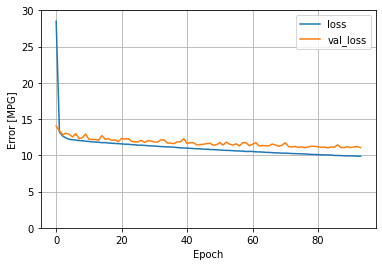

In [ ]:
plot_loss(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

119/119 - 0s - loss: 11.4654 - mae: 2.6370 - mse: 11.4654
Testing set Mean Abs Error:  2.64 MPG


In [ ]:
determineRegressionMetrics(test_labels, model.predict(normed_test_data), "MLP:")

MLP:
Mean absolute error = 2.64
Mean squared error = 11.47
Median absolute error = 2.15
R2 score = 0.63
Root Mean Squared Logarithmic Error = 0.30206334489118275


Save the model

In [ ]:
model.save(FS_ROOT_PATH + FILE_NAME.replace('.csv', '.h5'))